In [389]:
import pandas as pd
from pathlib import Path
from loguru import logger
import seaborn as sns
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [390]:
data_dir = Path("mhc")
df = pd.read_csv("./mhc_data.csv")
df.head()

,species,mhc,peptide_length,sequence,inequality,meas,job_name
0,human,HLA-A*02:01,9,YAAPQLFPV,=,1.000000,mhc_0
1,human,HLA-A*02:01,9,FLPDKAIDL,=,1.000000,mhc_1
2,human,HLA-A*02:01,9,FMFNDLLKL,=,1.000000,mhc_2
3,human,HLA-A*02:01,9,VLLPVLFGV,=,1.655212,mhc_3
4,human,HLA-A*02:01,9,FLNEDHWFS,=,9.682229,mhc_4


In [391]:
confidence_df = pd.read_csv("./results/af3_confidence.csv")
df.rename(columns={"job_name": "job_id"}, inplace=True)
df = pd.merge(df, confidence_df, on=["job_id"], how="right")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-19 22:35:07.590 | INFO     | __main__:<module>:6 - Below are examples of rows with missing values after merging:
2025-03-19 22:35:07.592 | INFO     | __main__:<module>:7 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score]
Index: []


In [392]:
deltag_df = pd.read_csv("./results/af3_deltag.csv")
df = pd.merge(df, deltag_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-19 22:35:07.635 | INFO     | __main__:<module>:5 - Below are examples of rows with missing values after merging:
2025-03-19 22:35:07.637 | INFO     | __main__:<module>:6 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_separated, dG_cross, sc_value, nres_all, nres_int, total_score, binding_energy]
Index: []

[0 rows x 26 columns]


In [393]:
df["meas_log"] = np.log(df["meas"])
df["neg_dG_cross"] = -df["dG_cross"]
df["neg_dG_separated"] = -df["dG_separated"]

In [394]:
def rerank_score(
    df: pd.DataFrame, metric: str, ascending: bool = False, mode: str = "global"
) -> pd.DataFrame:
    df = df.copy()
    if mode == "global":
        # Global rank: Rank within each (job_name, model_name) group
        df["global_rank_{}".format(metric)] = (
            df.groupby(["job_id"])[metric]
            .rank(
                method="first", ascending=ascending
            )  # Use 'first' for deterministic tie-breaking
            .astype(int)
        )
    elif mode == "local":
        df["local_rank_{}".format(metric)] = (
            df.groupby(["job_id", "seed_id"])[metric]
            .rank(
                method="first", ascending=ascending
            )  # Use 'first' to ensure ties are broken deterministically
            .astype(int)  # Convert to integers for cleaner output
        )
        df = df[df["local_rank_{}".format(metric)] <= 2]

        df["global_rank_{}".format(metric)] = (
            df.groupby(["job_id"])[metric]
            .rank(
                method="first", ascending=ascending
            )  # Use 'first' for deterministic tie-breaking
            .astype(int)
        )
        df.drop(columns=["local_rank_{}".format(metric)], inplace=True)
    return df

In [395]:
df = rerank_score(df, metric='dG_cross', ascending=True)
df = df[df["global_rank_dG_cross"] <= 1]

# df = rerank_score(df, metric='ranking_score', ascending=False)
# df = df[df["global_rank_ranking_score"] <= 1]

# df = rerank_score(df, metric='original_iptm', ascending=False)
# df = df[df["global_rank_original_iptm"] <= 1]

# df = rerank_score(df, metric='actifptm', ascending=False)
# df = df[df["global_rank_actifptm"] <= 1]

# df = rerank_score(df, metric='original_confidence_score', ascending=True)
# df = df[df["global_rank_original_confidence_score"] <= 1]

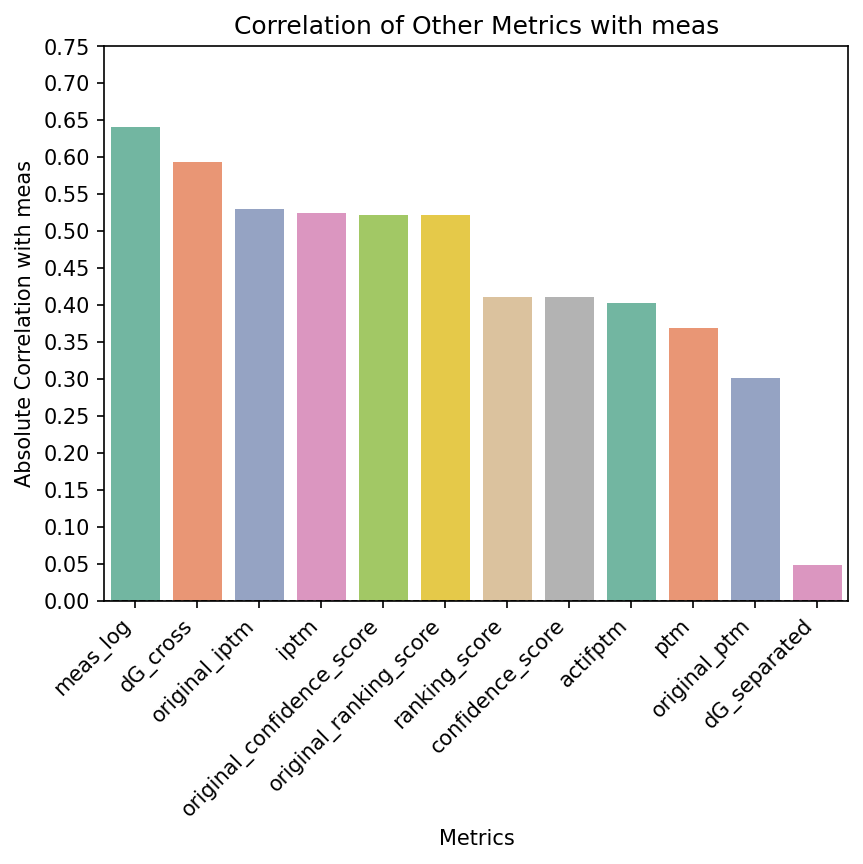

In [396]:
# 选取需要计算相关性的列
selected_columns = ["meas", "meas_log", "iptm", "original_iptm", "actifptm", "ptm", "original_ptm", 
                    "confidence_score", "original_confidence_score", "ranking_score", 
                    "original_ranking_score", "dG_cross", "dG_separated"]

# 计算 `meas` 与其他列的 Pearson 相关性，并取绝对值（将负数变正）
corr_series = df[selected_columns].corr(method="pearson")["meas"].drop("meas").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150)
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set2", legend=False)

plt.ylabel("Absolute Correlation with meas")
plt.xlabel("Metrics")
plt.yticks(np.arange(0, 0.8, 0.05))
plt.title("Correlation of Other Metrics with meas")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

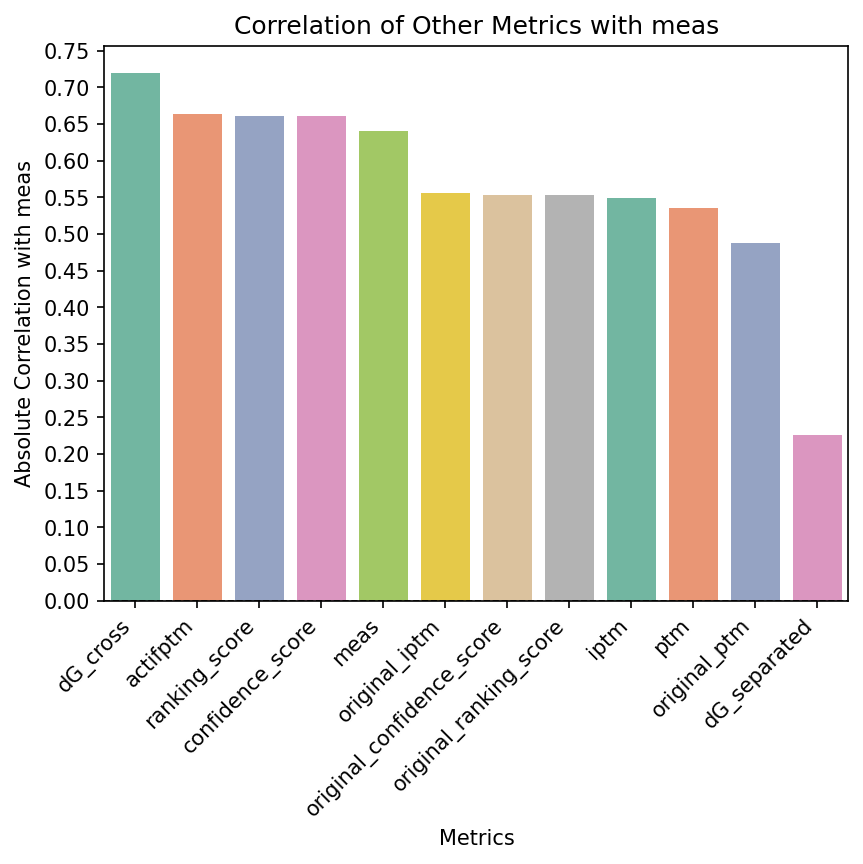

In [397]:
selected_columns = ["meas", "meas_log", "iptm", "original_iptm", "actifptm", "ptm", "original_ptm", 
                    "confidence_score", "original_confidence_score", "ranking_score", 
                    "original_ranking_score", "dG_cross", "dG_separated"]

# 计算 `meas` 与其他列的 Pearson 相关性，并取绝对值（将负数变正）
corr_series = df[selected_columns].corr(method="pearson")["meas_log"].drop("meas_log").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150)
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set2", legend=False)

plt.ylabel("Absolute Correlation with meas")
plt.xlabel("Metrics")
plt.yticks(np.arange(0, 0.8, 0.05))
plt.title("Correlation of Other Metrics with meas")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

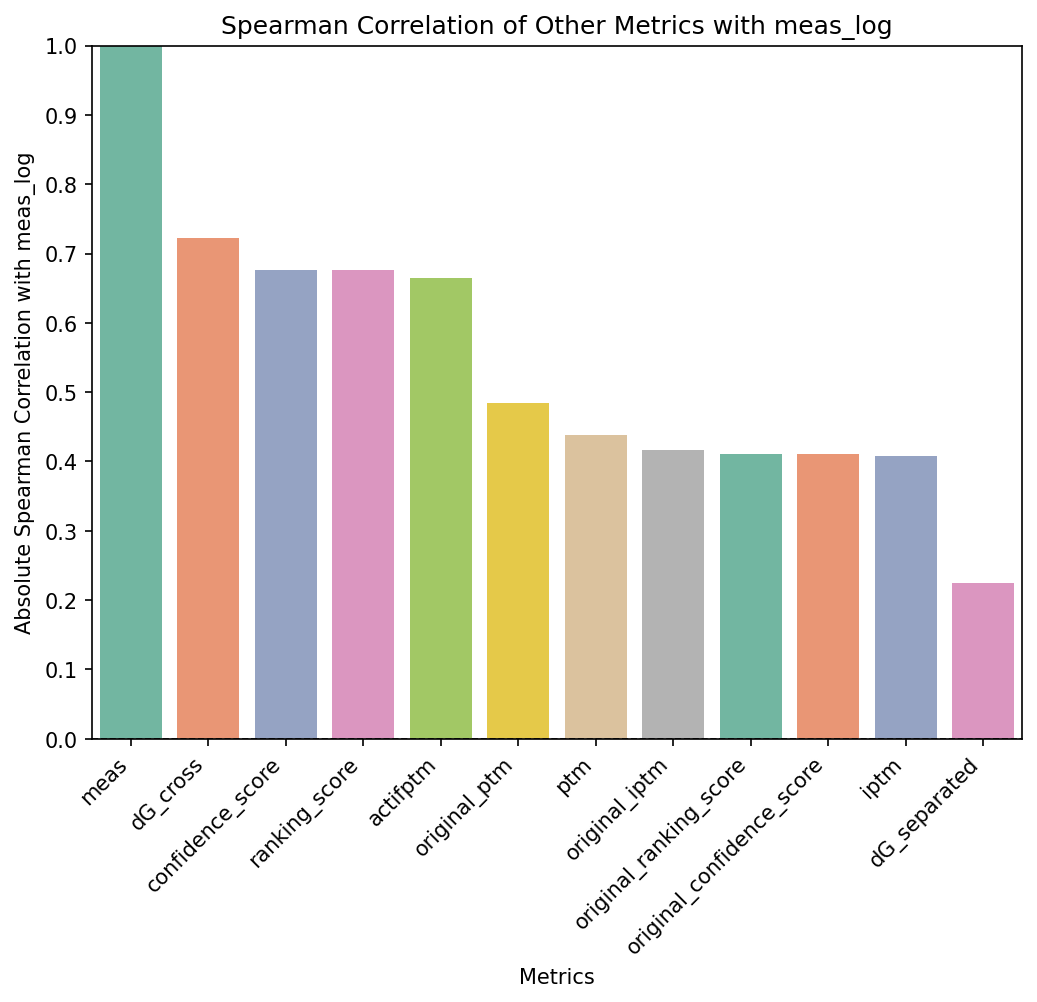

In [398]:
# 选取需要计算相关性的列
selected_columns = ["meas", "meas_log", "iptm", "original_iptm", "actifptm", "ptm", "original_ptm", 
                    "confidence_score", "original_confidence_score", "ranking_score", 
                    "original_ranking_score", "dG_cross", "dG_separated"]

# 计算 `meas_log` 与其他列的 Spearman 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="spearman")["meas_log"].drop("meas_log").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set2", legend=False)

plt.ylabel("Absolute Spearman Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Spearman Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

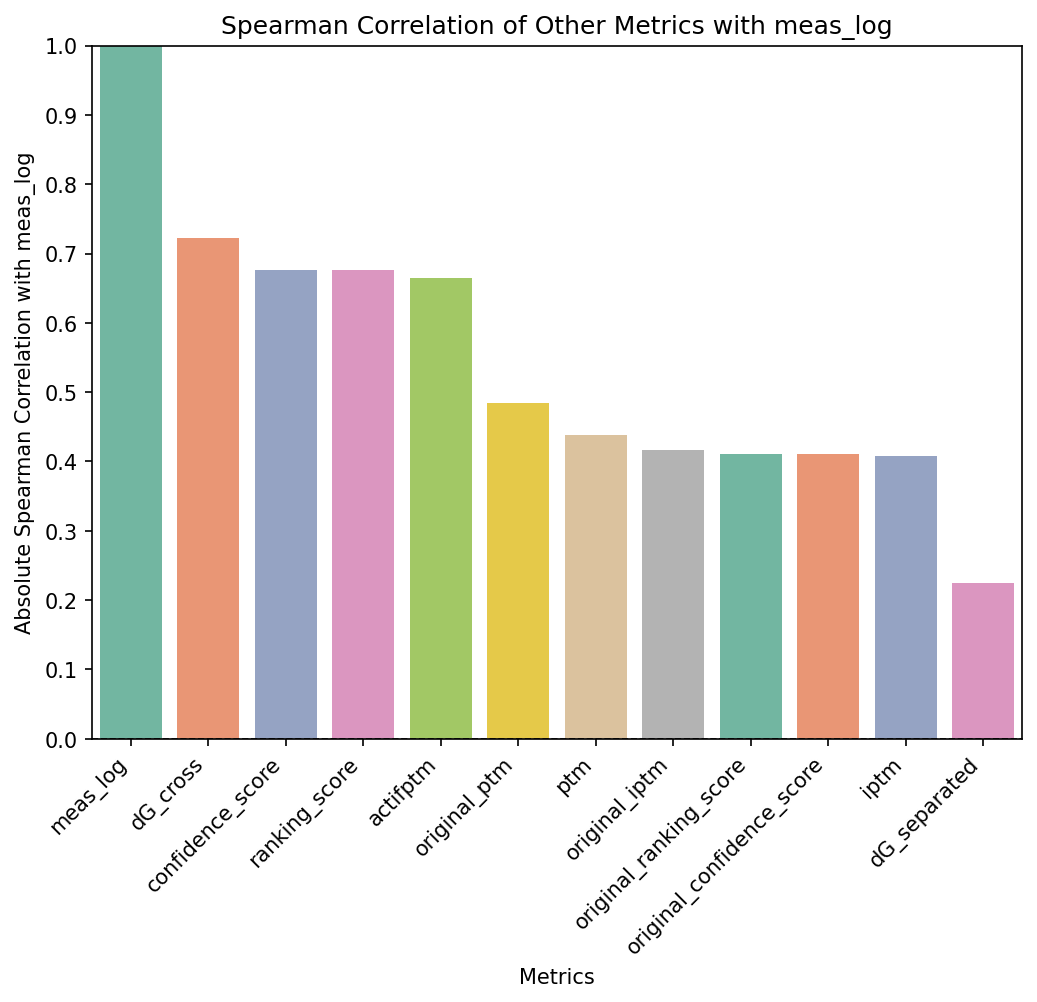

In [399]:
# 选取需要计算相关性的列
selected_columns = ["meas", "meas_log", "iptm", "original_iptm", "actifptm", "ptm", "original_ptm", 
                    "confidence_score", "original_confidence_score", "ranking_score", 
                    "original_ranking_score", "dG_cross", "dG_separated"]

# 计算 `meas_log` 与其他列的 Spearman 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="spearman")["meas"].drop("meas").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set2", legend=False)

plt.ylabel("Absolute Spearman Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Spearman Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

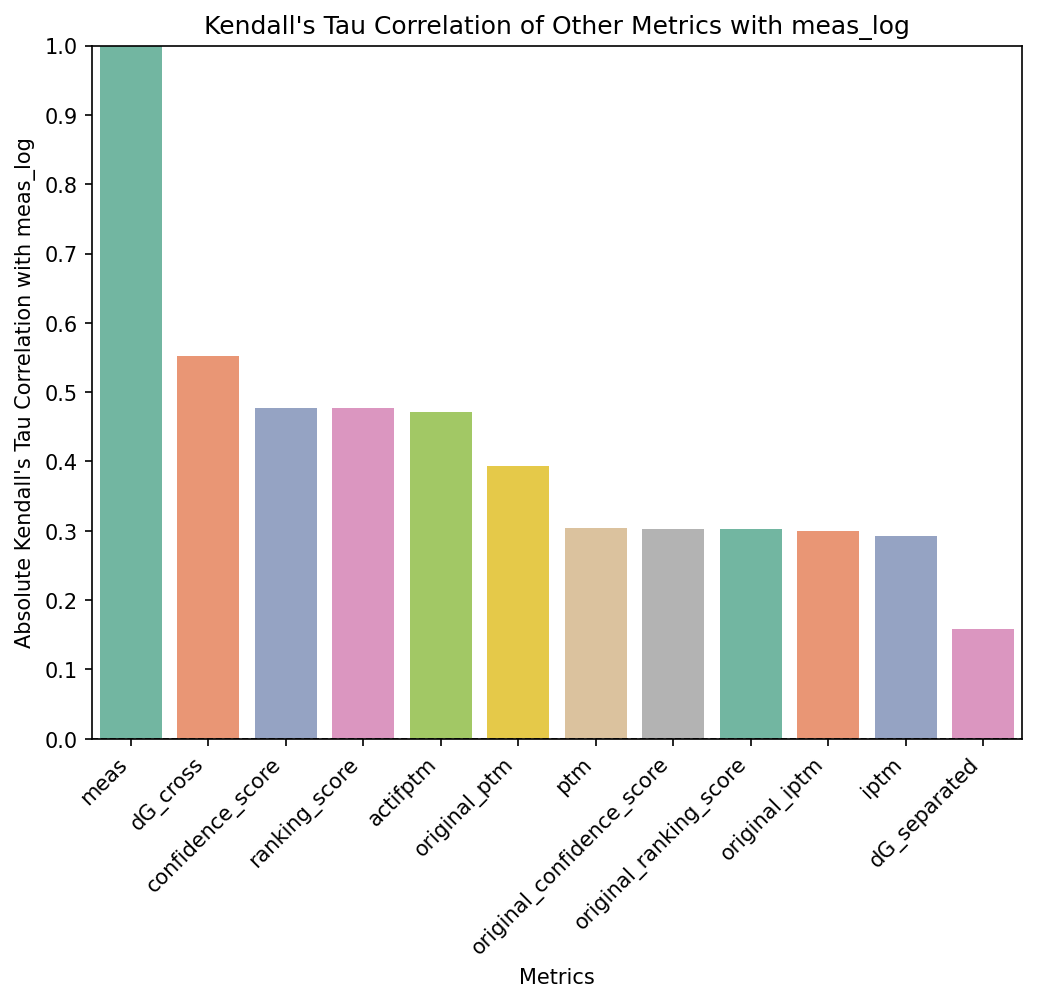

In [400]:

# 选取需要计算相关性的列
selected_columns = ["meas", "meas_log", "iptm", "original_iptm", "actifptm", "ptm", "original_ptm", 
                    "confidence_score", "original_confidence_score", "ranking_score", 
                    "original_ranking_score", "dG_cross", "dG_separated"]

# 计算 `meas_log` 与其他列的 Kendall 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="kendall")["meas_log"].drop("meas_log").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set2", legend=False)

plt.ylabel("Absolute Kendall's Tau Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Kendall's Tau Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

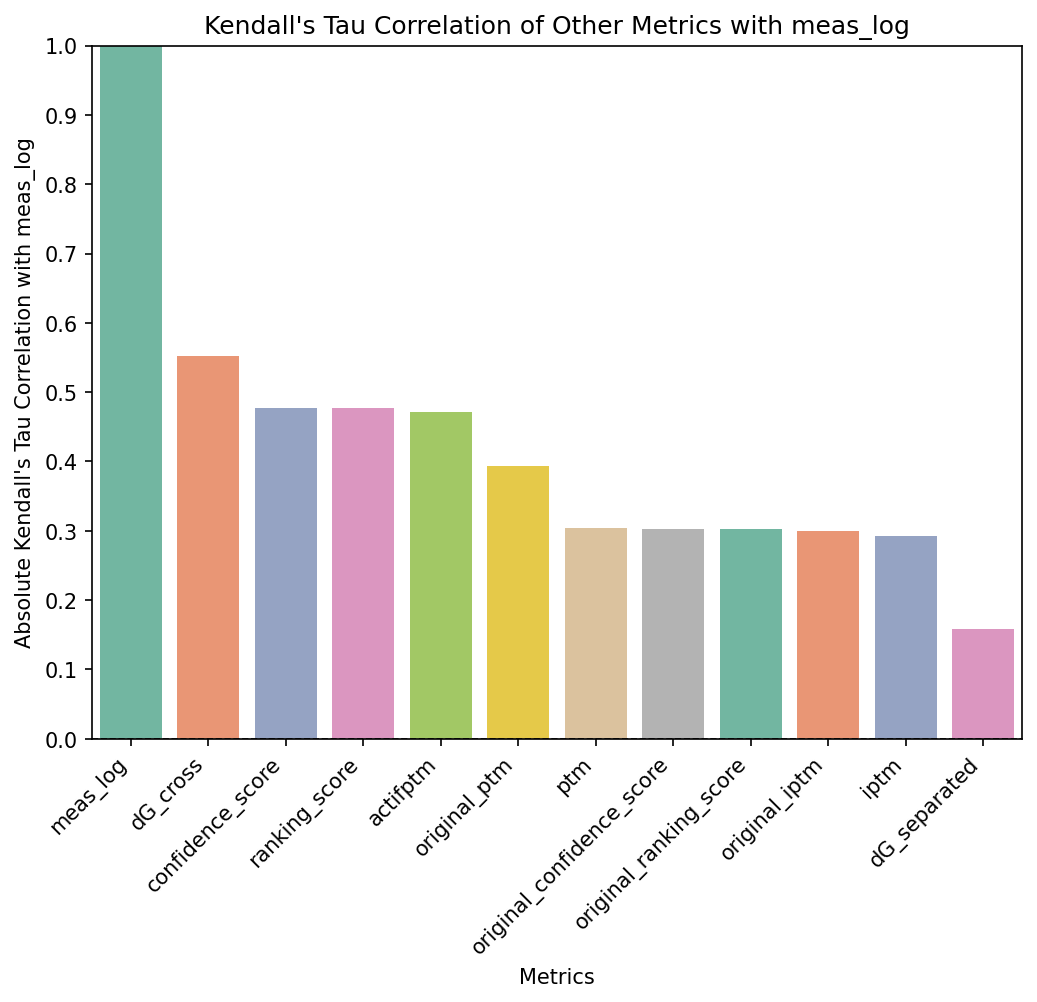

In [401]:

# 选取需要计算相关性的列
selected_columns = ["meas", "meas_log", "iptm", "original_iptm", "actifptm", "ptm", "original_ptm", 
                    "confidence_score", "original_confidence_score", "ranking_score", 
                    "original_ranking_score", "dG_cross", "dG_separated"]

# 计算 `meas_log` 与其他列的 Kendall 相关性，并取绝对值
corr_series = df[selected_columns].corr(method="kendall")["meas"].drop("meas").abs()

# 按相关性降序排序
corr_series = corr_series.sort_values(ascending=False)

# 画竖向条形图
plt.figure(dpi=150, figsize=(8, 6))
sns.barplot(x=corr_series.index, y=corr_series.values, hue=corr_series.index, palette="Set2", legend=False)

plt.ylabel("Absolute Kendall's Tau Correlation with meas_log")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.05, 0.1))  # 以 0.1 递增
plt.title("Kendall's Tau Correlation of Other Metrics with meas_log")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加中线

# 旋转 x 轴标签
plt.xticks(rotation=45, ha="right")

plt.show()

/tmp/ipykernel_128444/2414349983.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l1_distances.index, y=l1_distances.values, palette="Blues_r", ax=axes[0])
/tmp/ipykernel_128444/2414349983.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(l1_distances.index, rotation=45, ha="right")
/tmp/ipykernel_128444/2414349983.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=l2_distances.index, y=l2_distances.values, palette="Reds_r", ax=axes[1])
/tmp/ipykernel_128444/2414349983.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_t

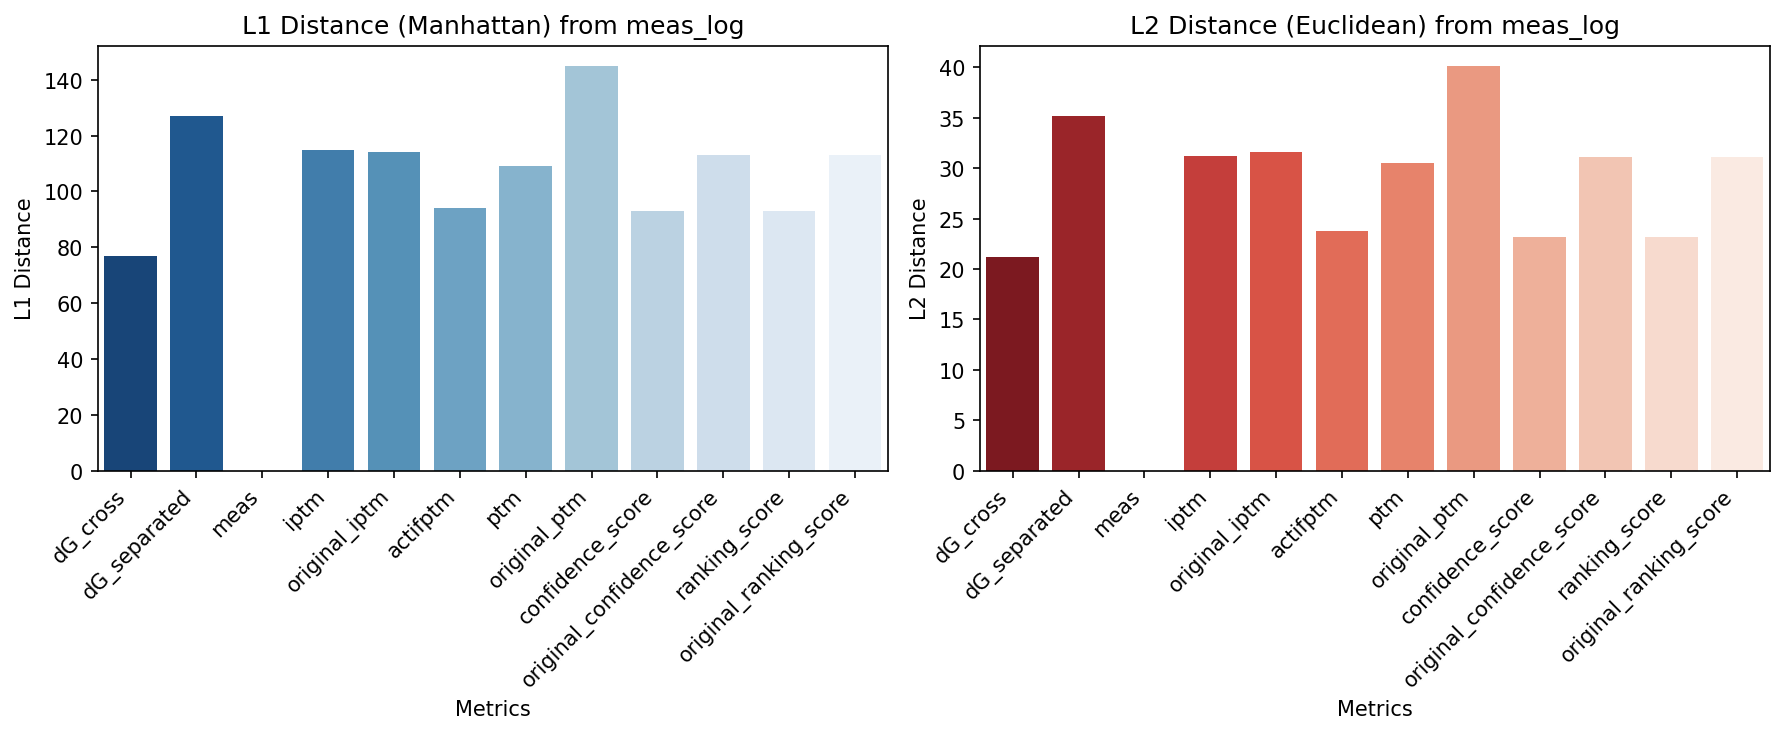

In [402]:
# 选取需要计算排名距离的列
descending_columns = [
    "iptm",
    "original_iptm",
    "actifptm",
    "ptm",
    "original_ptm",
    "confidence_score",
    "original_confidence_score",
    "ranking_score",
    "original_ranking_score",
]

ascending_columns = ["dG_cross", "dG_separated", "meas", "meas_log"]

rank_df_ascending = df[ascending_columns].rank(method="min", ascending=True)
rank_df_descending = df[descending_columns].rank(method="min", ascending=False)
rank_df = pd.concat([rank_df_ascending, rank_df_descending], axis=1)

# 计算 L1（曼哈顿距离）和 L2（欧几里得距离）
l1_distances = np.abs(rank_df.subtract(rank_df["meas_log"], axis=0)).sum()
l2_distances = np.sqrt((rank_df.subtract(rank_df["meas_log"], axis=0) ** 2).sum())

# 删除 `meas_log`（自身不计算距离）
l1_distances = l1_distances.drop("meas_log")
l2_distances = l2_distances.drop("meas_log")

# 可视化 L1 和 L2 距离
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# L1 距离
sns.barplot(x=l1_distances.index, y=l1_distances.values, palette="Blues_r", ax=axes[0])
axes[0].set_title("L1 Distance (Manhattan) from meas_log")
axes[0].set_ylabel("L1 Distance")
axes[0].set_xlabel("Metrics")
axes[0].set_xticklabels(l1_distances.index, rotation=45, ha="right")

# L2 距离
sns.barplot(x=l2_distances.index, y=l2_distances.values, palette="Reds_r", ax=axes[1])
axes[1].set_title("L2 Distance (Euclidean) from meas_log")
axes[1].set_ylabel("L2 Distance")
axes[1].set_xlabel("Metrics")
axes[1].set_xticklabels(l2_distances.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

/tmp/ipykernel_128444/2189447798.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kendall_series.index, y=kendall_series.values, palette="Purples_r")


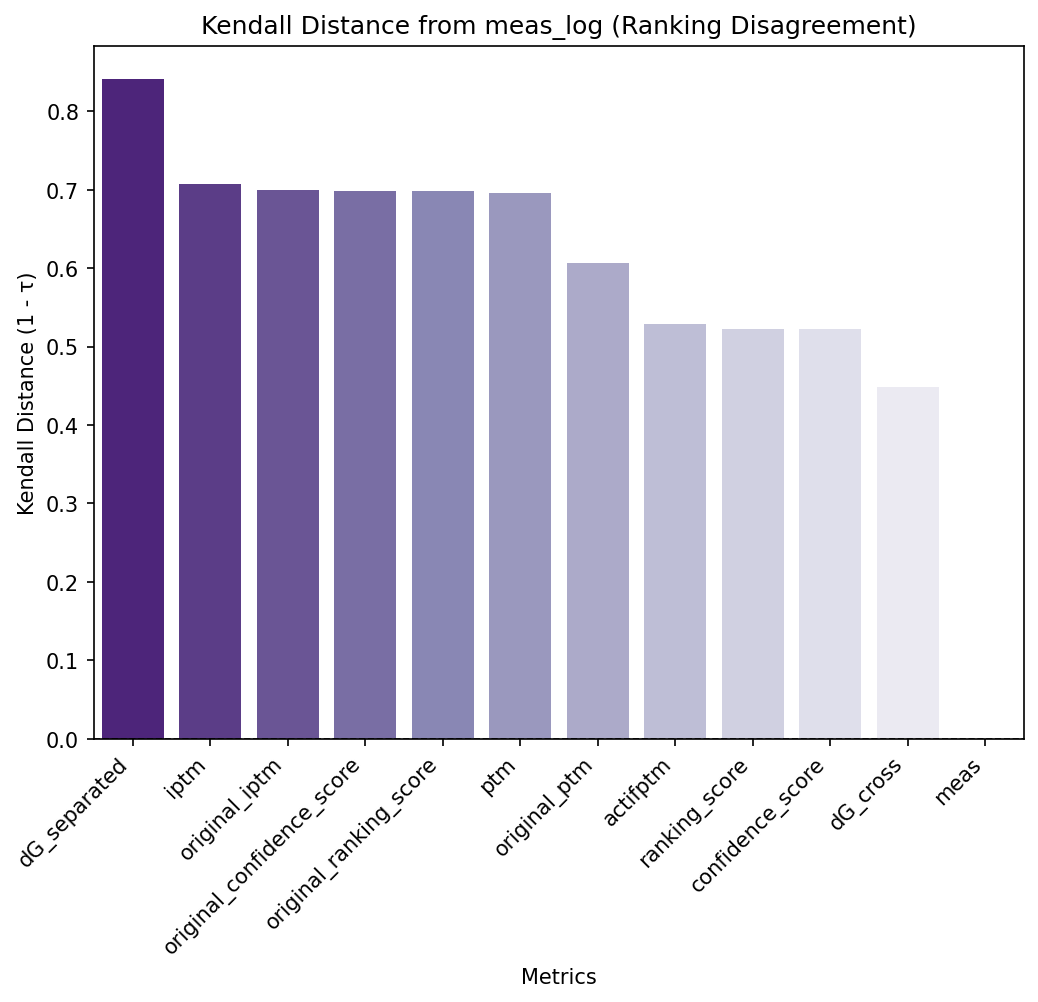

In [403]:
from scipy.stats import kendalltau

# 选取需要计算排名距离的列
descending_columns = [
    "iptm",
    "original_iptm",
    "actifptm",
    "ptm",
    "original_ptm",
    "confidence_score",
    "original_confidence_score",
    "ranking_score",
    "original_ranking_score",
]

ascending_columns = ["dG_cross", "dG_separated", "meas", "meas_log"]

rank_df_ascending = df[ascending_columns].rank(method="min", ascending=True)
rank_df_descending = df[descending_columns].rank(method="min", ascending=False)
rank_df = pd.concat([rank_df_ascending, rank_df_descending], axis=1)

# 计算 Kendall 距离
kendall_distances = {}

for col in selected_columns:
    if col != "meas_log":
        tau, _ = kendalltau(rank_df["meas_log"], rank_df[col])
        # Kendall 距离 = 1 - Kendall's Tau 相关系数（因为 τ 越小表示排名变化越大）
        kendall_distances[col] = 1 - tau

# 转换为 Pandas Series 并排序
kendall_series = pd.Series(kendall_distances).sort_values(ascending=False)

# 可视化 Kendall 距离
plt.figure(figsize=(8, 6), dpi=150)
sns.barplot(x=kendall_series.index, y=kendall_series.values, palette="Purples_r")

plt.ylabel("Kendall Distance (1 - τ)")
plt.xlabel("Metrics")
plt.title("Kendall Distance from meas_log (Ranking Disagreement)")
plt.xticks(rotation=45, ha="right")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)  # 添加参考线

plt.show()

In [408]:
from scipy.stats import kendalltau

# 选取需要计算排名距离的列
descending_columns = [
    "iptm",
    "original_iptm",
    "actifptm",
    "ptm",
    "original_ptm",
    "confidence_score",
    "original_confidence_score",
    "ranking_score",
    "original_ranking_score",
]

ascending_columns = ["dG_cross", "dG_separated", "meas", "meas_log"]

rank_df_ascending = df[ascending_columns].rank(method="min", ascending=True)
rank_df_descending = df[descending_columns].rank(method="min", ascending=False)
rank_df = pd.concat([rank_df_ascending, rank_df_descending], axis=1)

In [409]:
rank_df

,dG_cross,dG_separated,meas,meas_log,iptm,original_iptm,actifptm,ptm,original_ptm,confidence_score,original_confidence_score,ranking_score,original_ranking_score
18,17.0,12.0,19.0,19.0,17.0,17.0,17.0,20.0,20.0,18.0,18.0,18.0,18.0
119,20.0,15.0,21.0,21.0,21.0,21.0,18.0,18.0,16.0,19.0,21.0,19.0,21.0
272,21.0,4.0,20.0,20.0,9.0,9.0,19.0,13.0,1.0,17.0,9.0,17.0,9.0
354,15.0,18.0,18.0,18.0,20.0,20.0,21.0,19.0,16.0,21.0,20.0,21.0,20.0
468,18.0,21.0,16.0,16.0,19.0,19.0,20.0,21.0,20.0,20.0,19.0,20.0,19.0
551,8.0,5.0,13.0,13.0,3.0,2.0,10.0,10.0,1.0,10.0,3.0,10.0,3.0
603,19.0,11.0,17.0,17.0,18.0,17.0,13.0,9.0,1.0,12.0,17.0,12.0,17.0
733,2.0,19.0,15.0,15.0,6.0,2.0,6.0,5.0,1.0,5.0,6.0,5.0,6.0
831,11.0,14.0,14.0,14.0,5.0,2.0,14.0,2.0,1.0,13.0,5.0,13.0,5.0
911,14.0,16.0,12.0,12.0,11.0,11.0,5.0,11.0,1.0,7.0,11.0,7.0,11.0
